ranks:  [4.0, 1.0, 2.0, 3.0]
Pearson rank coefficient: 0.27
Spearman rank coefficient: 0.80


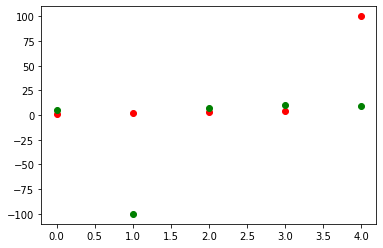

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

from tools import * 

config = pd.Series({
    'devide_by':5
})


l = [7, 1, 2, 5]
print("ranks: ", list2rank(l))

X = [1, 2, 3, 4, 100]
Y = [5, -100, 7, 10, 9]
plt.plot(X,'ro')
plt.plot(Y,'go')

print("Pearson rank coefficient: %.2f" % PearsonCorr(X, Y))
print("Spearman rank coefficient: %.2f" % spearmanRank(X, Y))

# Old data Febrer 2019 

In [ ]:
dades_2019_Febrer_info_old = pd.read_csv('../dades/2019/BICING_ESTACIONS/2019_02_Febrer_BICING_ESTACIONS.csv')

print(dades_2019_Febrer_info_old.shape)

dades_2019_Febrer_info_old.rename(
    columns={
        'id': 'station_id',
        'latitude':'lat',
        'longitude':'lon',
        'type':'physical_configuration',
        'updateTime':'last_updated',
        'bikes':'num_bikes_available',
        'slots':'num_docks_available',
        'streetName':'street_name',
        'streetNumber':'street_number',
    }, 
    inplace=True
)

# STATUS = IN_SERVICE=En servei, CLOSED=Tancada
# replace IN_SERVICE with 1 and CLOSED with 0
dades_2019_Febrer_info_old['status'].replace(to_replace=['CLS', 'OPN'], value=[0, 1], inplace=True)

dades_2019_Febrer_info_old['physical_configuration'].replace(to_replace=['BIKE', 'BIKE-ELECTRIC'], value=[0, 1], inplace=True)

dades_2019_Febrer_info_old['is_installed'] = 1
dades_2019_Febrer_info_old['is_renting'] = 1
dades_2019_Febrer_info_old['is_returning'] = 1
dades_2019_Febrer_info_old['is_charging_station'] = 1
dades_2019_Febrer_info_old['num_bikes_available_types.mechanical'] = dades_2019_Febrer_info_old['num_bikes_available']
dades_2019_Febrer_info_old['num_bikes_available_types.ebike'] = 0
dades_2019_Febrer_info_old['post_code'] = ''
dades_2019_Febrer_info_old['capacity'] = 0

# we don't have this column anywhere in the new dataset so it got removed
dades_2019_Febrer_info_old.drop('nearbyStations', axis=1, inplace=True)

dades_2019_Febrer_info_old = convert_timestamp(dades_2019_Febrer_info_old.copy(), ['last_updated'], sort=True, add=True, pattern='%d/%m/%y %H:%M:%S')

# convert timestamps to multimple of 5
dades_2019_Febrer_info_old = timestamp_multipleof(
    devide_by=config.devide_by, 
    column='minutes_last_updated_date',
    df=dades_2019_Febrer_info_old.copy(), 
    new_column='last_updated', 
    year_column='year_last_updated_date',
    month_column='month_last_updated_date',
    day_column='dayofmonth_last_updated_date',
    hour_column='hour_last_updated_date',
    minutes_column='minutes_last_updated_date'
)    

# drop not needed columns
dades_2019_Febrer_info_old.drop(
    [
        'year_last_updated_date', 'month_last_updated_date',
        'week_last_updated_date', 'dayofweek_last_updated_date',
        'dayofmonth_last_updated_date', 'dayofyear_last_updated_date',
        'hour_last_updated_date', 'minutes_last_updated_date'
    ], 
    axis=1, 
    inplace=True
)

print(dades_2019_Febrer_info_old.shape)

(3729928, 12)


In [ ]:
print_duplicates(dades_2019_Febrer_info_old, ['station_id', 'last_updated'])

In [ ]:
dades_2019_Febrer_info_old.columns

In [ ]:
# replace nans with string of 0
dades_2019_Febrer_info_old.street_number = dades_2019_Febrer_info_old.street_number.astype(str)
dades_2019_Febrer_info_old.street_number.fillna('0', inplace=True)
dades_2019_Febrer_info_old.loc[dades_2019_Febrer_info_old.street_number.isin(['nan', '.']),['street_number']] = '0' 

# extract the correct column
correct_column = dades_2019_Febrer_info_old[dades_2019_Febrer_info_old.street_number != '0'].groupby(['station_id'])['street_number'].max()
correct_column = pd.DataFrame(correct_column.reset_index())
# correct the data according to the data in the correct column
dades_2019_Febrer_info_old = correct_columns(dades_2019_Febrer_info_old.copy(), 'station_id', 'street_number', correct_column=correct_column)

dades_2019_Febrer_info_old.street_number.fillna('0', inplace=True)

dades_2019_Febrer_info_old = correct_columns(dades_2019_Febrer_info_old.copy(), 'station_id', 'capacity')

dades_2019_Febrer_info_old.loc[dades_2019_Febrer_info_old.capacity.isna(),['capacity']] = 0

dades_2019_Febrer_info_old = correct_columns(dades_2019_Febrer_info_old.copy(), 'station_id', 'altitude')

In [ ]:
cond = (dades_2019_Febrer_info_old.num_bikes_available + dades_2019_Febrer_info_old.num_docks_available) > dades_2019_Febrer_info_old.capacity
dades_2019_Febrer_info_old.loc[cond, ['capacity']] = dades_2019_Febrer_info_old[cond]['num_bikes_available'] + dades_2019_Febrer_info_old[cond]['num_docks_available']

In [ ]:
get_features_nans(dades_2019_Febrer_info_old)

In [ ]:
get_features_zero(dades_2019_Febrer_info_old)

In [ ]:
get_columns(dades_2019_Febrer_info_old)

In [ ]:
dades_2019_Febrer_info_old['ttl'] = 30.

In [ ]:
### will remove the duplicate for last reported for all stations in the dataset
dades_2019_Febrer_info_old = remove_duplicates_all(dades_2019_Febrer_info_old.copy(), 'last_updated')
# (3729928, 19)

In [ ]:
dades_2019_Febrer_info_old.shape

In [ ]:
f'{3729928-3728539} deleted'

In [ ]:
dades_2019_Febrer_info_old.to_csv('../dades/2019/BicingNou_ESTACIONS/2019_02_Febrer_BicingNou_ESTACIONS.csv')